# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 3

### Parte I: Limpieza de la base

In [ ]:
#!pip install openpyxl

In [3]:
# Importamos las librerías a usar

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


#### Lectura del documento

In [4]:
## 0. LECTURA DEL DOCUMENTO
df2024 = pd.read_excel('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx')
df2004 = pd.read_stata('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 3/Individual_t104.dta')

#Dirección de Maggie: "C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 3"
#Dirección de Peter: "C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx"

#### Filtrado de bases para tener solo Buenos Aires

In [51]:
df_2024_GB = df2024[(df2024['AGLOMERADO'] == 33) | (df2024['AGLOMERADO'] == 32)]
df_2004_GB = df2004[(df2004['aglomerado'] == 'Ciudad de Buenos Aires') | (df2004 ['aglomerado'] == 'Partidos del GBA' )]

df_2004_GB.columns = df_2004_GB.columns.str.upper()
df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)
#df_2024_GB['AGLOMERADO'].unique()
#df_2004_GB['aglomerado'].unique()

C:\Users\magda\AppData\Local\Temp\ipykernel_9424\3212184527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)


#### Preparación de la base de 2004
Se definen diccionarios de cambio para pasarlo a los mismos valores que tiene la base de 2024, se hacen solo los diccionarios de las variables que se van a usar después para la matriz de correlación. 
- Se hacen diccionarios
- Se vuelven a definir los valores a partir de los diccionarios
- Se chequea si hay valores extraños / no validos
- Se eliminan los ingresos y edades negativas y edades demasiado altas
- El resto de valores invalidos (CAT_INAC) se eliminan después cuando se verifique la base de 2024

In [52]:
#diccionarios de cambio
# El diccionario de la base de datos está un poco mal hecho, con diferencia a como se guardan los datos. que malditos
h04 = {
    "Varón": 1,
    "Mujer": 2
}

#Esto no aparece
h06 = {
    'Menos de 1 año': 0,
    '98 y más años': 98
}

#esto aparece con signos de pregunta
h07 = {
    "Unido": 1,
    "Casado": 2,
    "Separado o divorciado": 3,
    "Viudo": 4,
    "Soltero": 5
}

#Esto con mayusculas incosistentes
h08 =    {
    'Obra social (incluye PAMI)': 1,
    'Mutual/Prepaga/Servicio de emergencia': 2,
    'Planes y seguros públicos': 3,
    'No paga ni le descuentan': 4,
    'Ns./Nr.': 9,
    'Obra social y mutual/prepaga/servicio de emergencia': 12,
    'Obra social y planes y seguros públicos': 13,
    'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
    'Obra social, mutual/prepaga/servicio de emergencia y planes': 123
}

# 'Secundario incompleto' y en los datos aparece como 'Secuandaria incompleta', así con todo
nivel_ed= {
    'Primaria Incompleta (incluye educación especial)': 1,
    'Primaria Completa': 2,
    'Secundaria Incompleta': 3,
    'Secundaria Completa': 4,
    'Superior Universitaria Incompleta': 5,
    'Superior Universitaria Completa': 6,
    'Sin instrucción': 7,
    'Ns/Nr': 9
}

estado = {
    'Entrevista individual no realizada (no respuesta al cuestion': 0,
    'Ocupado': 1,
    'Desocupado': 2,
    'Inactivo': 3,
    'Menor de 10 años': 4
}

cat_inac = {
    'Jubilado/pensionado': 1,
    'Rentista': 2,
    'Estudiante': 3,
    'Ama de casa': 4,
    'Menor de 6 años': 5,
    'Discapacitado': 6,
    'Otros': 7
}

In [53]:
df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
df_2004_GB.loc[:,'CH04'] = df_2004_GB ['CH04'].map(h04).astype(int)
df_2004_GB.loc[:,'CH06'] = df_2004_GB ['CH06'].replace(h06).astype(int)
df_2004_GB.loc[:,'CH07'] = df_2004_GB ['CH07'].map(h07).astype(int)
df_2004_GB.loc[:,'CH08'] = df_2004_GB ['CH08'].map(h08).astype(int)
df_2004_GB.loc[:,'NIVEL_ED'] = df_2004_GB ['NIVEL_ED'].replace(nivel_ed).astype(int)
df_2004_GB.loc[:,'ESTADO'] = df_2004_GB ['ESTADO'].map(estado).astype(int)
df_2004_GB['IPCF'] =df_2004_GB['IPCF'].astype(int)

C:\Users\magda\AppData\Local\Temp\ipykernel_9424\3832139500.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
C:\Users\magda\AppData\Local\Temp\ipykernel_9424\3832139500.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
C:\Users\magda\AppData\Local\Temp\ipykernel_9424\3832139500.py:1: FutureWarning: Setting an item of incompatible dtyp

##### Entiendo los datos que vamos a usar
##### Observo los valores y frecuencia de esos valores en los datos para revisar que los datos tengan sentido y sigan las claves de los diccionarios oroginales. Se encuentra que CAT_INAC tiene 3617 datos en valor '0' (tiene precibir datos entre 1 y 7)

In [54]:
# CH04 está bien
# CH06 parece que está bien
# CH07 está bien
# CH08 está bien, no se observa '13'
# NIVEL_ED está bien, no se observa '7', o '8'
# ESTADO está bien
# CAT_INAC tiene la mitad de los datos como'0' (son 3617 datos no validos)

lista_valores_matriz = ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC']
for i in lista_valores_matriz:
    print(df_2004_GB[i].value_counts())

CH04
2    4045
1    3602
Name: count, dtype: int64
CH06
13    153
22    146
14    139
17    138
7     137
     ... 
93      4
98      4
90      3
94      2
96      1
Name: count, Length: 96, dtype: int64
CH07
5    3687
2    2372
1     821
4     429
3     338
Name: count, dtype: int64
CH08
1     3568
4     3296
2      610
12     111
3       47
9       11
23       4
Name: count, dtype: int64
NIVEL_ED
2    1628
1    1406
3    1374
4    1086
7     805
5     701
6     647
Name: count, dtype: int64
ESTADO
1    3079
3    2800
4    1230
2     528
0      10
Name: count, dtype: int64
CAT_INAC
0    3617
3    1594
4     816
5     763
1     668
7     134
6      41
2      14
Name: count, dtype: int64


In [55]:
# Define los límites
maximo_edad = 130 # totalmente arbitrario, pero sirve para sacar extraños muy extraños

# Filtra el DataFrame, manteniendo solo los valores dentro del rango
df_2004_GB = df_2004_GB[(df_2004_GB['IPCF'] >= 0)]
df_2004_GB = df_2004_GB[(df_2004_GB['CH06'] >= 0) & (df_2004_GB['CH06'] <= maximo_edad)]

#### Preparación de base de datos de 2024
Se chequean los valores extraños / sin sentido, se eliminan los invalidos de ingreso y edad. 


In [120]:
# RESET
#df_2024_GB = df2024[(df2024['AGLOMERADO'] == 33) | (df2024['AGLOMERADO'] == 32)]
# La base tiene 7051 observaciones

In [56]:
# Define los límites
maximo_edad = 130 # totalmente arbitrario, pero sirve para sacar extraños muy extraños

# Filtra el DataFrame, manteniendo solo los valores dentro del rango
df_2004_GB = df_2004_GB[(df_2004_GB['IPCF'] >= 0)]
df_2004_GB = df_2004_GB[(df_2004_GB['CH06'] >= 0) & (df_2004_GB['CH06'] <= maximo_edad)]

##### Otra vez, CAT_INAC tiene mucho invalidos

In [57]:
# Me fijo los valores y la frecuencia

#CH07 tiene '9'
#CH08 está bien, no tiene ninguno 123
#NIVEL_ED está bien, no tiene 8 o 9
#ESTADO está bien
#CAT_INAC tiene mitad de los valores como 0 (3576 observaciones no validas)
df_2024_GB['CAT_INAC'].value_counts()

CAT_INAC
0    3576
3    1440
1     717
4     653
5     402
7     186
6      59
2      18
Name: count, dtype: int64

#### Eliminación de ambas bases previo al merge
se elimina los extraños de ambas bases de datos (CAT_INAC =0)

In [58]:
valores_validos = {
    'CH04': [1,2],
    'CH07': [1,2,3,4,5],
    'CH08': [1,2,3,4,9,12,13,23,123],
    'NIVEL_ED': [1,2,3,4,5,6,7,8,9],
    'ESTADO': [0,1,2,3,4],
    'CAT_INAC': [0,1,2,3,4,5,6,7] 
} #'CH06' Y 'IPCF' quedan excluidos porque tiene condiciones de min y max

for col in valores_validos.keys():
    df_2024_GB = df_2024_GB[df_2024_GB[col].isin(valores_validos[col])]
    df_2004_GB = df_2004_GB[df_2004_GB[col].isin(valores_validos[col])]

In [59]:
lista_valores_matriz = ['CH04',  'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC'] 
for i in lista_valores_matriz:
    datos = df_2024_GB[i].value_counts()
    print ('los valores de ', i, 'son:', datos)

# CH04 BIEN
# CH06 MAL: TIENE -1
# CH07 MAL: TIENE 9 
# EL DE ESTADO ESTA MAL. VA DE 0 A 4. 

los valores de  CH04 son: CH04
2    3678
1    3360
Name: count, dtype: int64
los valores de  CH07 son: CH07
5    3375
2    1507
1    1297
3     459
4     400
Name: count, dtype: int64
los valores de  CH08 son: CH08
1     4308
4     2024
2      566
12     121
9       13
13       3
3        2
23       1
Name: count, dtype: int64
los valores de  NIVEL_ED son: NIVEL_ED
4    1607
3    1412
6    1108
5     879
1     867
2     743
7     422
Name: count, dtype: int64
los valores de  ESTADO son: ESTADO
1    3224
3    2662
4     813
2     311
0      28
Name: count, dtype: int64
los valores de  CAT_INAC son: CAT_INAC
0    3563
3    1440
1     717
4     653
5     402
7     186
6      59
2      18
Name: count, dtype: int64


In [60]:
#IDENTIFICO COLUMNAS QUE DIFIEREN ENTRE LAS BASES
col2004 = df_2004_GB.columns
col2024 = df_2024_GB.columns

# Encontrar columnas que son diferentes
columnas_df1 = set(col2004)
columnas_df2 = set(col2024)

# Columnas en df1 pero no en df2
diferentes_df1 = columnas_df1 - columnas_df2
# Columnas en df2 pero no en df1
diferentes_df2 = columnas_df2 - columnas_df1

# Comparar columnas comunes para ver diferencias en valores
diferencias_valores = {}
for col in columnas_df1.intersection(columnas_df2):
    if not df_2004_GB[col].equals(df_2024_GB[col]):
        diferencias_valores[col] = (df_2004_GB[col].tolist(), df_2024_GB[col].tolist())

print("Columnas solo en 2004:", diferentes_df1)
print("Columnas solo en 2024:", diferentes_df2)
#print("Diferencias en valores:", diferencias_valores)


Columnas solo en 2004: {'PJ3_1', 'IDIMPP', 'PJ2_1', 'PJ1_1'}
Columnas solo en 2024: {'IMPUTA', 'CH05', 'PONDII', 'PONDIH', 'PONDIIO'}


In [65]:
#ELIMINO LAS COLUMNAS QUE DIFIEREN Y LAS QUE RESULTAN IRRELEVANTES
del_col1 = ['PJ3_1', 'IDIMPP', 'PJ2_1', 'PJ1_1', 'CODUSU']
del_col2 = ['IMPUTA', 'CH05', 'PONDII', 'PONDIH', 'PONDIIO','CODUSU']

df_2004_GB =df_2004_GB.drop(columns = del_col1)
df_2024_GB =df_2024_GB.drop(columns = del_col2)

# df_combined = df.drop(columns=['B', 'C'])

In [66]:
# Uno ambos trimestres en una sola base
df_combined = pd.concat([df_2004_GB, df_2024_GB], ignore_index=True, sort=False)
#df_GB = df_2004_GB

In [68]:
df_combined

,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR
0,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Jefe,...,02,,01,368,07,,06,06,,04
1,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Jefe,...,00,,00,0,00,,00,00,,00
2,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Jefe,...,03,,02,440,07,,07,07,,05
3,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Jefe,...,09,,08,532,08,,08,08,,06
4,1.0,2.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Cónyuge/Pareja,...,09,,08,532,08,,08,08,,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14680,1.0,1,1,2024.0,1,1,S,33,3410.0,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14681,1.0,2,2,2024.0,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14682,1.0,3,2,2024.0,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14683,1.0,4,2,2024.0,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12


### Parte II: Visualizaciones

In [70]:
df_combined.describe()

,NRO_HOGAR,ANO4,PONDERA,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,...,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,IPCF
count,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,...,14685.000000,1.468500e+04,14685.000000,14685.000000,14685.000000,14685.0,1.468500e+04,1.468500e+04,1.468500e+04,1.468500e+04
mean,1.025128,2013.585291,1930.239224,1.525911,35.667416,3.465645,2.370378,3.620293,2.215798,1.708682,...,35.980456,2.984049e+03,90.251958,1236.392509,75.482942,0.0,2.764744e+03,2.588546e+04,2.181629e+05,7.704687e+04
std,0.599744,9.991737,898.962687,0.499345,22.885446,1.613835,1.920061,1.849940,1.149572,1.984922,...,3446.288100,2.502312e+05,1541.525415,17430.855928,5629.474501,0.0,2.877672e+04,2.762454e+05,7.840004e+05,2.784104e+05
min,1.000000,2004.000000,42.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-9.000000,-9.000000e+00,-9.000000,-9.000000,-9.000000,0.0,-9.000000e+00,-9.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2004.000000,1441.000000,1.000000,16.000000,2.000000,1.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,2.500000e+02,6.000000e+01
50%,1.000000,2004.000000,1685.000000,2.000000,33.000000,4.000000,1.000000,3.000000,3.000000,1.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,1.000000e+03,2.660000e+02
75%,1.000000,2024.000000,2232.000000,2.000000,53.000000,5.000000,4.000000,5.000000,3.000000,3.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,1.750000e+05,5.600000e+04
max,51.000000,2024.000000,8685.000000,2.000000,98.000000,5.000000,23.000000,7.000000,4.000000,7.000000,...,400000.000000,3.000000e+07,80000.000000,800000.000000,540000.000000,0.0,2.000000e+06,3.010000e+07,3.393700e+07,1.131233e+07


<Axes: xlabel='CH04'>

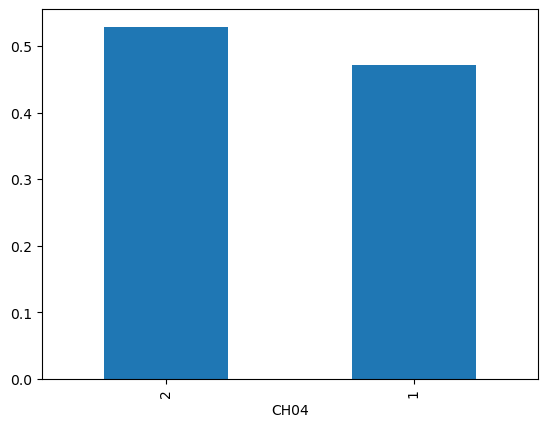

In [71]:
# #COMPOSICIÓN POR SEXO PARA 2004 Y 2024
# #CH04: Sexo. 1=Varón, 2=Mujer
# #ANO4: Año (2004, 2024)

df_2004_GB['CH04'].value_counts(1).plot.bar()

# ax = df_2004_GB[['CH04']].plot(kind='bar', title ="Composición por sexo para 2004 y 2024", figsize=(15, 10), legend=True, fontsize=12)
# ax.set_xlabel("Año", fontsize=12)
# ax.set_ylabel("Cantidad", fontsize=12)
# plt.show() 

In [ ]:
# #MATRIZ DE CORRELACIÓN

#UNA PARA 2004 Y OTRA PARA 2024

# df = pd.DataFrame(
#     {
#         "Day 1": [7, 1, 5, 6, 3, 10, 5, 8],
#         "Day 2": [1, 2, 8, 4, 3, 9, 5, 2],
#         "Day 3": [4, 6, 5, 8, 6, 1, 2, 3],
#         "Day 4": [5, 8, 9, 5, 1, 7, 8, 9],
#     }
# )

# upp_mat = np.triu(df.corr())

# sns.heatmap(df.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm", mask=upp_mat)

In [72]:
#COUNT: DESOCUPADOS, INACTIVOS, OCUPADOS

print("Estado 2004:", df_2004_GB["ESTADO"].value_counts())
print("Estado 2024:", df_2024_GB["ESTADO"].value_counts()) #ACA HAY ALGO RARO PORQUE LOS VALORES TENDRIAN Q IR D 0 A 4. 

Estado 2004: ESTADO
1    3079
3    2800
4    1230
2     528
0      10
Name: count, dtype: int64
Estado 2024: ESTADO
1    3224
3    2662
4     813
2     311
0      28
Name: count, dtype: int64


In [73]:
df_2024_GB['ESTADO'].head()


245    1
246    1
247    1
255    1
256    3
Name: ESTADO, dtype: int64

In [74]:
#INGRESO PER CÁPITA FAMILIAR SEGÚN ESTADO (OCUPADO, DESOCUPADO, INACTIVO)
#IPCF: Monto de ingreso per capita familiar percibido
#ESTADO: 0 = Entrevista individual no realizada (no respuesta al cuestionario individual)
    # 1 = Ocupado
    # 2 = Desocupado
    # 3 = Inactivo
    # 4 = Menor de 10 años

df_combined["IPCF"].groupby(df_combined["ESTADO"]).describe()


,count,mean,std,min,25%,50%,75%,max
ESTADO,,,,,,,,
0,38.0,13.815789,53.735013,0.0,0.0,0.0,0.0,294.0
1,6303.0,106443.281295,382731.337327,0.0,50.0,337.0,79800.0,11312333.0
2,839.0,31655.797378,81410.436494,0.0,65.0,183.0,705.0,908750.0
3,5462.0,63862.957342,175238.209647,0.0,66.0,251.0,66750.0,5875000.0
4,2043.0,41675.026432,123001.677718,0.0,58.0,183.0,1066.5,1733333.0


In [75]:
#ARMAR BASE DE RESPONDIERON Y NO RESPONDIERON

respondieron= df_combined.loc[(df_combined["ESTADO"]>0)]

norespondieron = df_combined.loc[(df_combined["ESTADO"]==0)] #10 personas no respondieron. 

def det_pea(estado): 
    return 1 if estado in [1,2] else 0

respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)

def det_pet(edad): 
    return 1 if 15 <= edad <= 65 else 0

respondieron["PET"]= respondieron["CH06"].apply(det_pet)

def det_deso(estado): 
    return 1 if estado == 2 else 0

respondieron["desocupado"]= respondieron["ESTADO"].apply(det_deso)


C:\Users\magda\AppData\Local\Temp\ipykernel_9424\441820110.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\magda\AppData\Local\Temp\ipykernel_9424\441820110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\magda\AppData\Local\Temp\ipykernel_9424\441820110.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [76]:
respondieron["desocupado"].value_counts()

desocupado
0    13808
1      839
Name: count, dtype: int64

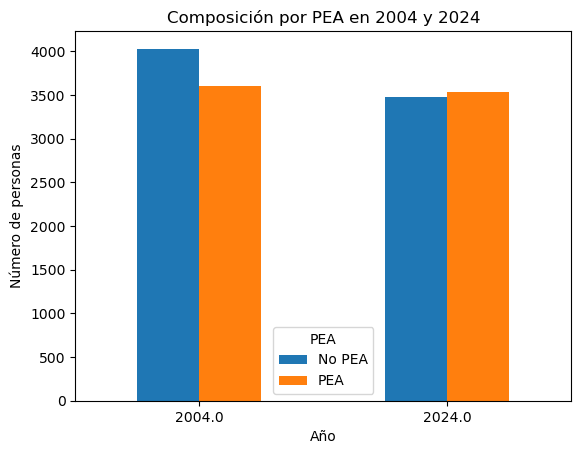

Total PET: 9568
Total PEA: 7142


In [77]:
# Agrupar datos por año y PEA
resultados = respondieron.groupby(['ANO4', 'PEA']).size().unstack(fill_value=0)

# Crear gráfico de barras
resultados.plot(kind='bar')
plt.title('Composición por PEA en 2004 y 2024')
plt.xlabel('Año')
plt.ylabel('Número de personas')
plt.xticks(rotation=0)
plt.legend(['No PEA', 'PEA'], title='PEA')
plt.show()

# Comparar PET y PEA
total_pet = respondieron['PET'].sum()
total_pea = respondieron['PEA'].sum()

print(f'Total PET: {total_pet}')
print(f'Total PEA: {total_pea}')

In [78]:
respondieron

,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PEA,PET,desocupado
0,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Jefe,...,368,07,,06,06,,04,0,0,0
1,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Jefe,...,0,00,,00,00,,00,1,0,0
2,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Jefe,...,440,07,,07,07,,05,0,0,0
3,1.0,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Jefe,...,532,08,,08,08,,06,1,1,0
4,1.0,2.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Cónyuge/Pareja,...,532,08,,08,08,,06,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14676,1.0,1,1,2024.0,1,1,S,33,2818.0,1,...,0,12,NaN,12,12.0,NaN,12,0,0,0
14677,1.0,2,1,2024.0,1,1,S,33,2818.0,2,...,0,12,NaN,12,12.0,NaN,12,1,1,1
14678,1.0,3,1,2024.0,1,1,S,33,2818.0,3,...,0,12,NaN,12,12.0,NaN,12,1,1,0
14679,1.0,4,1,2024.0,1,1,S,33,2818.0,3,...,0,12,NaN,12,12.0,NaN,12,1,1,0


In [ ]:
# Divido la base 'respondieron' para cada año
df_combined['ANO4'] = df_combined ['ANO4'].astype(int) #lo cambio porque me da cosita que está en float
resp_2004 = df_combined[df_combined['ANO4'] == 2004]
resp_2024 = df_combined [df_combined['ANO4'] == 2004]

train_2004, test_2004 = train_test_split(resp_2004, test_size=0.3, random_state=101)
train_2024, test_2024 = train_test_split(resp_2024, test_size=0.3, random_state=101)